![AIRBNB](https://www.stevenridercpa.au/wp-content/uploads/2022/09/airbnb-tax.jpeg)

In [182]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Obligatorio de Deep Learning
## Semestre 2 - 2023
-------

## Problema

Se presenta un dataset que contiene información de alojamientos publicados en AirBnB con sus respectivos precios. El tamaño del dataset de train es de 1.5 Gb aproximadamente, y 0.5 Gb el de test. Este cuenta con 84 variables predictoras que se podrán utilizar como consideren adecuado.

El objetivo es asignar el precio correcto a los alojamientos listados.

Además del dataset se les provee esta notebook conteniendo el script de carga de datos y un modelo baseline que corresponde a una arquitectura feed forward.

------

## Consigna

### A) <u>Participación en Competencia Kaggle</u>:
El objetivo de este punto es participar en la competencia de Kaggle y obtener como mínimo un Mean Absolute Error inferior a 70 puntos. [->Link a la competencia<-](https://www.kaggle.com/t/69c648e3aa214d1f812bf2314c8d4ffa).

### B) <u>Utilización de Grid Search (o equivalente)</u>:
Para cumplir con la busqueda de modelos óptimos se debe realizar un grid search lo más abarcativo y metódico posible. Recomendamos enfáticamente [Weights and Biases](https://wandb.ai/site)

### C) <u>Se debe a su vez investigar e implementar las siguientes técnicas</u>:
#### 1. [Batch Normalization](https://machinelearningmastery.com/how-to-accelerate-learning-of-deep-neural-networks-with-batch-normalization/)
#### 2. [Gradient Normalization y/o Gradient Clipping](https://machinelearningmastery.com/how-to-avoid-exploding-gradients-in-neural-networks-with-gradient-clipping/)


Además como en todas las tareas se evaluará la prolijidad de la entrega, el preprocesamiento de datos, visualizaciones y exploración de técnicas alternativas.

-------

## 1. Setup
### 1.1 Imports

In [183]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

### 1.2 Seteo de seeds

In [184]:
np.random.seed(117)
tf.random.set_seed(117)

## 2. Carga de datos

Datos para predicción

In [185]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [186]:
import os


os.listdir('/content/drive/MyDrive/Data/')

['P_2017_Terceros.sav', 'private_data_to_predict.csv', 'public_train_data.csv']

In [187]:
!cp '/content/drive/MyDrive/Data/public_train_data.csv' '/content/'

In [188]:
df = pd.read_csv('public_train_data.csv')

In [189]:
df.shape

(326287, 85)

In [190]:
!cp '/content/drive/My Drive/utils.py' '/content/'

cp: cannot stat '/content/drive/My Drive/utils.py': No such file or directory


##  3. Análisis exploratorio de datos
### 3.1 Dimensiones

In [191]:
df.shape

(326287, 85)

### 3.2 Obtener información sobre las columnas y tipos de datos

In [192]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 326287 entries, 0 to 326286
Data columns (total 85 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   id                              326287 non-null  int64  
 1   Last Scraped                    326286 non-null  object 
 2   Name                            326018 non-null  object 
 3   Summary                         315651 non-null  object 
 4   Space                           228792 non-null  object 
 5   Description                     326188 non-null  object 
 6   Experiences Offered             326287 non-null  object 
 7   Neighborhood Overview           192513 non-null  object 
 8   Notes                           130729 non-null  object 
 9   Transit                         200649 non-null  object 
 10  Access                          177108 non-null  object 
 11  Interaction                     169193 non-null  object 
 12  House Rules     

### 3.3 Visualizar las primeras filas del dataset

In [193]:
df.head(3)

,id,Last Scraped,Name,Summary,Space,Description,Experiences Offered,Neighborhood Overview,Notes,Transit,...,Review Scores Location,Review Scores Value,License,Jurisdiction Names,Cancellation Policy,Calculated host listings count,Reviews per Month,Geolocation,Features,Price
0,0,2017-05-12,Grand Loft in the heart of historic Antwerp,Best location for visiting Antwerp!! Beautiful...,Welcome in Antwerp!! The loft is situated on t...,Best location for visiting Antwerp!! Beautiful...,none,NaN,NaN,NaN,...,10.0,9.0,NaN,NaN,strict,2.0,2.6,"51.21938762207894, 4.4034442505151885","Host Has Profile Pic,Instant Bookable",159.0
1,1,2017-05-03,"CHARMING, CLEAN & COZY BUNGALOW!",Very centrally located and less than 15 min fr...,"Well lit, private entrance with small patio.",Very centrally located and less than 15 min fr...,none,"Quiet. Pretty tree lined streets, safe area.",Has dining table and high back desk chair.,"Uber, bus line and metro link is less than 5 m...",...,NaN,NaN,NaN,"City of Los Angeles, CA",flexible,1.0,NaN,"34.1892692286356, -118.41993491931177","Host Has Profile Pic,Is Location Exact",49.0
2,2,2017-05-09,la casa di maurizio,"nice apartment with view to via veneto , very ...",NaN,"nice apartment with view to via veneto , very ...",none,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,flexible_new,1.0,NaN,"41.90859623057272, 12.493518028459327","Host Has Profile Pic,Is Location Exact",75.0


### 3.4 Estadísticas descriptivas

In [194]:
df.describe()

,id,Host ID,Host Response Rate,Host Listings Count,Host Total Listings Count,Latitude,Longitude,Accommodates,Bathrooms,Bedrooms,...,Review Scores Rating,Review Scores Accuracy,Review Scores Cleanliness,Review Scores Checkin,Review Scores Communication,Review Scores Location,Review Scores Value,Calculated host listings count,Reviews per Month,Price
count,326287.000000,3.262870e+05,250845.000000,325971.000000,325970.000000,326287.000000,326287.000000,326244.000000,325300.000000,325873.000000,...,243160.000000,242584.000000,242732.000000,242378.000000,242710.000000,242423.000000,242347.000000,325689.000000,246983.000000,326287.000000
mean,163143.000000,3.236757e+07,93.408264,9.586000,9.586026,38.042816,-15.323924,3.270764,1.239482,1.358072,...,92.880063,9.524713,9.326067,9.691416,9.708253,9.468215,9.321031,6.881531,1.486211,138.229041
std,94191.087979,3.174572e+07,17.536835,57.399711,57.399797,22.910029,70.101677,2.037446,0.574784,0.921763,...,8.569521,0.855361,1.038858,0.731702,0.723143,0.805116,0.906478,42.025986,1.752082,149.790527
min,0.000000,1.900000e+01,0.000000,0.000000,0.000000,-38.224427,-123.218712,1.000000,0.000000,0.000000,...,20.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,1.000000,0.010000,0.000000
25%,81571.500000,6.869780e+06,98.000000,1.000000,1.000000,38.923154,-73.968081,2.000000,1.000000,1.000000,...,90.000000,9.000000,9.000000,10.000000,10.000000,9.000000,9.000000,1.000000,0.320000,55.000000
50%,163143.000000,2.186737e+07,100.000000,1.000000,1.000000,42.304549,0.090277,2.000000,1.000000,1.000000,...,95.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,1.000000,0.890000,90.000000
75%,244714.500000,4.799166e+07,100.000000,3.000000,3.000000,50.863658,12.342749,4.000000,1.000000,2.000000,...,100.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,2.000000,2.040000,150.000000
max,326286.000000,1.350885e+08,100.000000,1114.000000,1114.000000,55.994889,153.637837,18.000000,8.000000,96.000000,...,100.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,752.000000,223.000000,999.000000


In [195]:
df.columns

Index(['id', 'Last Scraped', 'Name', 'Summary', 'Space', 'Description',
       'Experiences Offered', 'Neighborhood Overview', 'Notes', 'Transit',
       'Access', 'Interaction', 'House Rules', 'Thumbnail Url', 'Medium Url',
       'Picture Url', 'XL Picture Url', 'Host ID', 'Host URL', 'Host Name',
       'Host Since', 'Host Location', 'Host About', 'Host Response Time',
       'Host Response Rate', 'Host Acceptance Rate', 'Host Thumbnail Url',
       'Host Picture Url', 'Host Neighbourhood', 'Host Listings Count',
       'Host Total Listings Count', 'Host Verifications', 'Street',
       'Neighbourhood', 'Neighbourhood Cleansed',
       'Neighbourhood Group Cleansed', 'City', 'State', 'Zipcode', 'Market',
       'Smart Location', 'Country Code', 'Country', 'Latitude', 'Longitude',
       'Property Type', 'Room Type', 'Accommodates', 'Bathrooms', 'Bedrooms',
       'Beds', 'Bed Type', 'Amenities', 'Square Feet', 'Security Deposit',
       'Cleaning Fee', 'Guests Included', 'Extra Peop

### 3.5 Análisis de valores Nulos

In [196]:
#Cantidad de nulos
null_count = df.isnull().sum()
#Porcentaje de nulos por columna
null_percentage = (df.isnull().mean()) * 100
#Dataframe
null_info = pd.DataFrame({'Col': null_count.index, 'Cant_Nulos': null_count, 'Share_nulos': null_percentage})

Revisamos las columnas con mayor porcentaje de valores faltantes.

Se decide eliminar del dataset las columnas con mas de 30% de valores nulos por considerar que es un valor muy elevado para imputar.

In [197]:
null_info[null_info['Share_nulos']>=30].sort_values(by='Share_nulos', ascending=False)

,Col,Cant_Nulos,Share_nulos
Has Availability,Has Availability,320038,98.084815
Square Feet,Square Feet,318294,97.550316
License,License,316483,96.995283
Host Acceptance Rate,Host Acceptance Rate,298657,91.531995
Neighbourhood Group Cleansed,Neighbourhood Group Cleansed,257990,79.068427
Jurisdiction Names,Jurisdiction Names,236872,72.596211
Notes,Notes,195558,59.934352
Security Deposit,Security Deposit,190145,58.275383
Interaction,Interaction,157094,48.145957
Access,Access,149179,45.720179


In [198]:
cols_eliminar1=null_info[null_info['Share_nulos']>=30]['Col'].to_list()

In [199]:
df=df.drop(cols_eliminar1, axis=1)

In [200]:
len(cols_eliminar1)

16

Eliminamos todas las columnas cuya información sea una url (como por ejemplo Host Picture Url o Host Thumbnail Url) por no ser de utilidad para el modelo

In [201]:
df[['Host Picture Url','Host Thumbnail Url']].head()

,Host Picture Url,Host Thumbnail Url
0,https://a0.muscache.com/im/pictures/5271a897-2...,https://a0.muscache.com/im/pictures/5271a897-2...
1,https://a0.muscache.com/im/pictures/58bde558-c...,https://a0.muscache.com/im/pictures/58bde558-c...
2,https://a0.muscache.com/im/pictures/6272bc04-d...,https://a0.muscache.com/im/pictures/6272bc04-d...
3,https://a0.muscache.com/im/pictures/44ac861d-7...,https://a0.muscache.com/im/pictures/44ac861d-7...
4,https://a0.muscache.com/im/pictures/7a052645-e...,https://a0.muscache.com/im/pictures/7a052645-e...


In [202]:
df['Host Picture Url'][0]

'https://a0.muscache.com/im/pictures/5271a897-245b-41cb-8ef9-7a45f1d1ef91.jpg?aki_policy=profile_x_medium'

In [203]:
cols_eliminar2 = [col for col in df.columns if 'Url' in col]
df=df.drop(cols_eliminar2,axis=1)

In [204]:
cols_eliminar3 = [col for col in df.columns if 'URL' in col]
df=df.drop(cols_eliminar3,axis=1)

In [205]:
#Cantidad de nulos
null_count = df.isnull().sum()
#Porcentaje de nulos por columna
null_percentage = (df.isnull().mean()) * 100
#Dataframe
null_info = pd.DataFrame({'Col': null_count.index, 'Cant_Nulos': null_count, 'Share_nulos': null_percentage})

País: eliminamos la columna "Country" ya que representa lo mismo que Country Code

In [206]:
len(set(df['Country Code']))

22

In [207]:
len(set(df['Country']))

22

In [208]:
df=df.drop('Country',axis=1)

Eliminamos las columnas HostName y Host_Id por no ser útiles para el modelo

In [209]:
cols_eliminar4=['Host Name','Host ID']
df=df.drop(cols_eliminar4, axis=1)

Location: las columnas Latitude&Longitude representan lo mismo que Geolocation.

Igualmente se decide eliminar las 3 variables del dataset ya que en principio se entiende que el modelo puede performar bien sin esta información.

En caso que sea necesario luego del entrenamiento agregar más variables se evaluará si se vuelven a incluir.

In [210]:
df[['Latitude','Longitude','Geolocation']].head(10)

,Latitude,Longitude,Geolocation
0,51.219388,4.403444,"51.21938762207894, 4.4034442505151885"
1,34.189269,-118.419935,"34.1892692286356, -118.41993491931177"
2,41.908596,12.493518,"41.90859623057272, 12.493518028459327"
3,41.883985,12.499185,"41.883984550594604, 12.499185366336528"
4,40.720983,-73.997836,"40.72098312129154, -73.99783555096808"
5,48.859354,2.308245,"48.85935433452363, 2.308245117928801"
6,48.879162,2.371675,"48.87916169458883, 2.371675497225248"
7,40.816603,-73.937020,"40.816602667155735, -73.93702018967657"
8,-37.809188,144.986107,"-37.8091875093531, 144.98610729053317"
9,51.430897,-0.119824,"51.430896573331204, -0.11982396382815948"


In [211]:
df=df.drop(['Geolocation'],axis=1)

In [212]:
df[['Calendar last Scraped','Calendar Updated','Last Scraped','Last Review']].head(5)

,Calendar last Scraped,Calendar Updated,Last Scraped,Last Review
0,2017-05-12,6 weeks ago,2017-05-12,2017-04-26
1,2017-05-02,4 weeks ago,2017-05-03,NaN
2,2017-05-08,18 months ago,2017-05-09,NaN
3,2017-05-08,a week ago,2017-05-09,2017-04-29
4,2017-05-04,today,2017-05-04,2017-05-01


Se decide eliminar las variables Calendar Updated y Calendar last scraped ya que contamos con la variable Last Review que creemos es más útil para el modelo

In [213]:
df=df.drop(['Calendar Updated'],axis=1)

In [214]:
df[['Summary','Description']].head()

,Summary,Description
0,Best location for visiting Antwerp!! Beautiful...,Best location for visiting Antwerp!! Beautiful...
1,Very centrally located and less than 15 min fr...,Very centrally located and less than 15 min fr...
2,"nice apartment with view to via veneto , very ...","nice apartment with view to via veneto , very ..."
3,In un quartiere tranquillo un'accogliente came...,In un quartiere tranquillo un'accogliente came...
4,"The apartment is bright, clean and simple in a...","The apartment is bright, clean and simple in a..."


**Variables Strings**
En principio no se incluyen las variables como Name / Description por ser strings muy extensos.

En caso que el modelo no performe bien y sea necesario incluir más variables se evaluará de incluirlas.

In [215]:
df[['Name','Summary','Space','Description']].head()

,Name,Summary,Space,Description
0,Grand Loft in the heart of historic Antwerp,Best location for visiting Antwerp!! Beautiful...,Welcome in Antwerp!! The loft is situated on t...,Best location for visiting Antwerp!! Beautiful...
1,"CHARMING, CLEAN & COZY BUNGALOW!",Very centrally located and less than 15 min fr...,"Well lit, private entrance with small patio.",Very centrally located and less than 15 min fr...
2,la casa di maurizio,"nice apartment with view to via veneto , very ...",NaN,"nice apartment with view to via veneto , very ..."
3,Camera a due passi dal Colosseo NEW,In un quartiere tranquillo un'accogliente came...,"L'appartamento è nel centro storico di Roma, i...",In un quartiere tranquillo un'accogliente came...
4,Perfectly Located Apartment in Downtown Manhattan,"The apartment is bright, clean and simple in a...",No need to waste money on bogus frills. The ha...,"The apartment is bright, clean and simple in a..."


In [216]:
df=df.drop(['Name','Summary','Space','Description'],axis=1)

# EDA

### Realizamos un análisis más profundo de las 49 columnas restantes

Para eso dividimos las columnas en subgrupos que agrupen variables con características similares, esto nos permite un mejor entendimiento de la base de datos, también nos facilita identificar si 2 columnas tienen información muy similar y están correlacionadas.

In [217]:
len(df.columns)

53

In [218]:
df.columns

Index(['id', 'Last Scraped', 'Experiences Offered', 'Host Since',
       'Host Location', 'Host Response Time', 'Host Response Rate',
       'Host Neighbourhood', 'Host Listings Count',
       'Host Total Listings Count', 'Host Verifications', 'Street',
       'Neighbourhood Cleansed', 'City', 'State', 'Zipcode', 'Market',
       'Smart Location', 'Country Code', 'Latitude', 'Longitude',
       'Property Type', 'Room Type', 'Accommodates', 'Bathrooms', 'Bedrooms',
       'Beds', 'Bed Type', 'Amenities', 'Guests Included', 'Extra People',
       'Minimum Nights', 'Maximum Nights', 'Availability 30',
       'Availability 60', 'Availability 90', 'Availability 365',
       'Calendar last Scraped', 'Number of Reviews', 'First Review',
       'Last Review', 'Review Scores Rating', 'Review Scores Accuracy',
       'Review Scores Cleanliness', 'Review Scores Checkin',
       'Review Scores Communication', 'Review Scores Location',
       'Review Scores Value', 'Cancellation Policy',
       'Ca

In [219]:
host = ['Host Response Time','Host Since','Host Verifications','Host Response Rate']
listings=['Calculated host listings count','Host Listings Count','Host Total Listings Count']
availability=['Availability 30','Availability 60','Availability 90','Availability 365']
geo=['Latitude','Longitude','Street','Country','City','State','Zipcode','Smart Location','Neighbourhood Cleansed','Host Neighbourhood','Market','Host Location']
alojamiento=['Beds','Room Type','Bed Type','Amenities','Guests Included','Extra People','Bathrooms','Bedrooms','Accommodates','Minimum Nights','Maximum Nights','Features','Cancellation Policy','Property Type','Experiences Offered']
reviews=['Last Scraped','Calendar last Scraped','Reviews per Month','Number of Reviews','First Review','Last Review','Review Scores Rating','Review Scores Accuracy','Review Scores Checkin','Review Scores Cleanliness','Review Scores Value','Review Scores Communication','Review Scores Location']

In [220]:
#Check para ver que no estamos olvidando ninguna columna
len(host)+len(listings)+len(availability)+len(geo)+len(alojamiento)+len(reviews)+2

53

### **Variables relativas al alojamiento**

In [221]:
df[alojamiento].head()

,Beds,Room Type,Bed Type,Amenities,Guests Included,Extra People,Bathrooms,Bedrooms,Accommodates,Minimum Nights,Maximum Nights,Features,Cancellation Policy,Property Type,Experiences Offered
0,4.0,Entire home/apt,Real Bed,"TV,Cable TV,Wireless Internet,Kitchen,Elevator...",6.0,25.0,1.0,2.0,6.0,2.0,51.0,"Host Has Profile Pic,Instant Bookable",strict,Apartment,none
1,1.0,Private room,Real Bed,"TV,Internet,Wireless Internet,Air conditioning...",1.0,0.0,1.0,1.0,2.0,1.0,7.0,"Host Has Profile Pic,Is Location Exact",flexible,House,none
2,1.0,Private room,Real Bed,"TV,Wireless Internet,Air conditioning,Breakfas...",1.0,0.0,1.0,1.0,2.0,1.0,1125.0,"Host Has Profile Pic,Is Location Exact",flexible_new,Apartment,none
3,1.0,Private room,Real Bed,"Breakfast,Elevator in building,Heating,Washer,...",1.0,0.0,1.0,1.0,2.0,2.0,1125.0,"Host Is Superhost,Host Has Profile Pic,Is Loca...",moderate_new,Apartment,none
4,1.0,Entire home/apt,Real Bed,"Internet,Wireless Internet,Air conditioning,Ki...",2.0,20.0,1.0,1.0,2.0,1.0,1125.0,"Host Has Profile Pic,Is Location Exact,Instant...",strict,Apartment,none


In [222]:
df[alojamiento].isnull().sum()

Beds                    594
Room Type                 0
Bed Type                  0
Amenities              2888
Guests Included           1
Extra People             13
Bathrooms               987
Bedrooms                414
Accommodates             43
Minimum Nights            1
Maximum Nights            1
Features                195
Cancellation Policy       1
Property Type             7
Experiences Offered       0
dtype: int64

### Variables numéricas

In [223]:
df[alojamiento].describe()

,Beds,Guests Included,Extra People,Bathrooms,Bedrooms,Accommodates,Minimum Nights,Maximum Nights
count,325693.000000,326286.000000,326274.000000,325300.000000,325873.000000,326244.000000,326286.000000,3.262860e+05
mean,1.909587,1.539968,11.243758,1.239482,1.358072,3.270764,3.329631,2.471806e+05
std,1.453753,1.195037,27.060328,0.574784,0.921763,2.037446,24.054478,2.198811e+07
min,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000e+00
25%,1.000000,1.000000,0.000000,1.000000,1.000000,2.000000,1.000000,3.200000e+01
50%,1.000000,1.000000,0.000000,1.000000,1.000000,2.000000,2.000000,1.125000e+03
75%,2.000000,2.000000,15.000000,1.000000,2.000000,4.000000,3.000000,1.125000e+03
max,19.000000,18.000000,999.000000,8.000000,96.000000,18.000000,9999.000000,2.147484e+09


<ipython-input-224-17d00ddb44c8>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = df[alojamiento].corr()


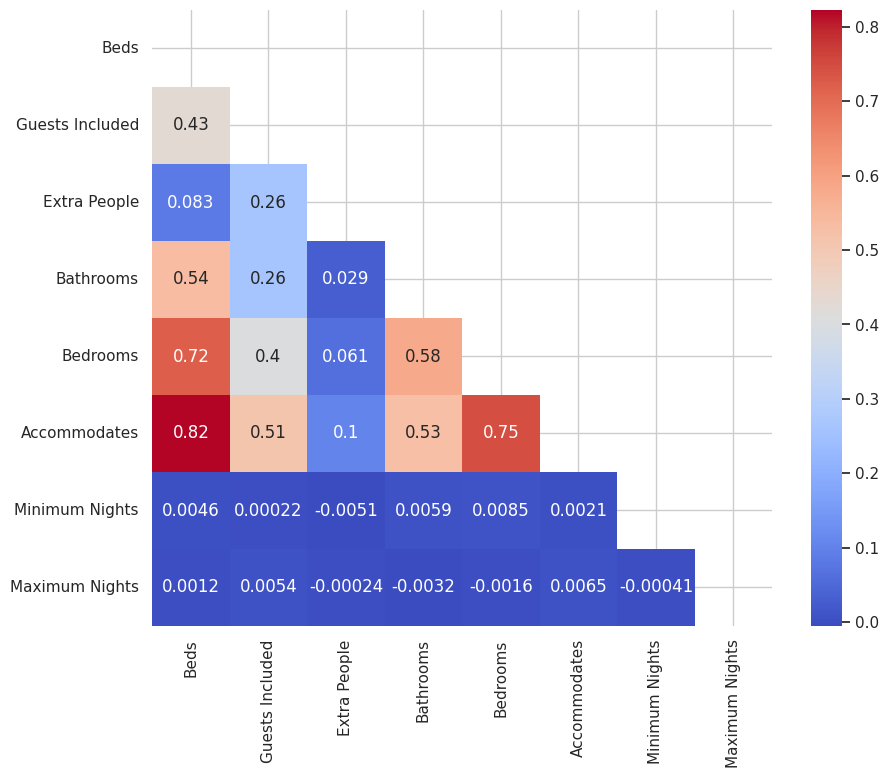

In [224]:
corr = df[alojamiento].corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(corr, annot=True, cmap='coolwarm', ax=ax, mask=mask)
plt.show()

In [225]:
df[['Beds', 'Accommodates','Bedrooms','Price']].corr()['Price']

Beds            0.293338
Accommodates    0.373885
Bedrooms        0.361354
Price           1.000000
Name: Price, dtype: float64

Las variables Accommodates, Bedrooms y Beds están altamente correlacionadas  por lo cual se decide conservar únicamente una para evitar problemas de multicolinealidad  en el modelo.

Se conserva la variable Accomodates ya que tiene mayor correlación con la variable objetivo (0.37 vs 0.29 y 0.36)

Existen otras correlaciones moderadas como por ejemplo Bathrooms con Beds, pero se mantienen dado que su nivel se entiende que no perjudicarán el modelo por su nivel moderado (~0.5).

In [226]:
df=df.drop(['Beds','Bedrooms'],axis=1)

In [227]:
alojamiento=['Price','Room Type','Bed Type','Amenities','Guests Included','Extra People','Bathrooms','Accommodates','Minimum Nights','Maximum Nights','Features','Cancellation Policy','Property Type','Experiences Offered']

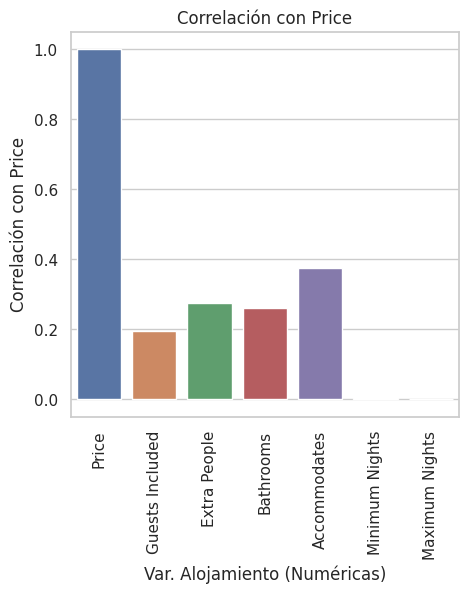

In [228]:
df_numeric = df[alojamiento].select_dtypes(include=['int64', 'float64'])
correlation_with_price = df_numeric.corr()['Price']

plt.figure(figsize=(5, 5))
sns.barplot(x=correlation_with_price.index, y=correlation_with_price.values)
plt.xticks(rotation=90)
plt.xlabel("Var. Alojamiento (Numéricas)")
plt.ylabel("Correlación con Price")
plt.title("Correlación con Price")
plt.show()

Se eliminan las variables Minimum/Maximum Night por no tener correlación con la variable objetivo

In [229]:
df=df.drop(['Minimum Nights','Maximum Nights'],axis=1)

### Variables categóricas

### Cancellation type

In [230]:
df['Cancellation Policy'].value_counts(normalize=True)

strict                 0.368401
flexible               0.315643
moderate               0.247436
moderate_new           0.023875
strict_new             0.020942
flexible_new           0.019320
super_strict_60        0.002446
super_strict_30        0.001790
super_strict_30_new    0.000083
super_strict_60_new    0.000049
no_refunds             0.000012
long_term              0.000003
Name: Cancellation Policy, dtype: float64

<Axes: xlabel='Cancellation Policy', ylabel='Price'>

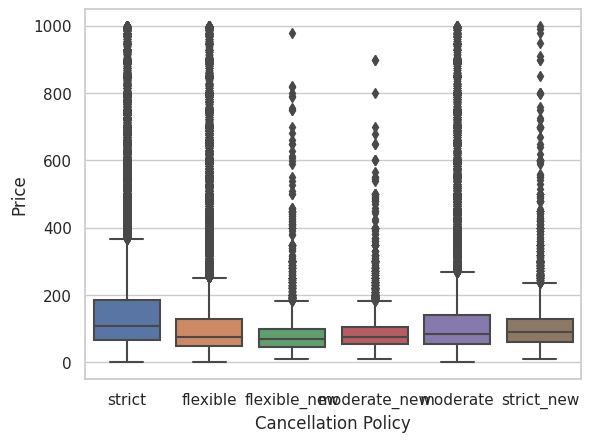

In [231]:
filtered_df = df[df['Cancellation Policy'].isin(['strict', 'flexible', 'moderate','moderate_new','strict_new','flexible_new'])]
sns.boxplot(x='Cancellation Policy', y='Price', data=filtered_df)

In [232]:
canc_types = ['strict', 'flexible', 'moderate','moderate_new','strict_new','flexible_new']
df.loc[~df['Cancellation Policy'].isin(canc_types), 'Cancellation Policy'] = 'strict'

In [233]:
df['Cancellation Policy'].value_counts(normalize=True)

strict          0.372785
flexible        0.315642
moderate        0.247436
moderate_new    0.023875
strict_new      0.020942
flexible_new    0.019320
Name: Cancellation Policy, dtype: float64

Se decide limitar las categorias de esta variable ya que son en total 12 pero las primeras 6 acumulan el 99% de las observaciones. En el 1% restante se decide imputar el valor Scrict ya que es el valor con mayor cantidad de observaciones (37%).

In [234]:
mapeo = {'flexible_new': 1, 'flexible': 2,'moderate_new':3, 'moderate':4,'strict_new':5,'strict':6}
df['Cancellation Policy'] = df['Cancellation Policy'].map(mapeo)

## Room type

In [235]:
df['Room Type'].value_counts(normalize=True)

Entire home/apt    0.629182
Private room       0.352720
Shared room        0.018094
9                  0.000003
Name: Room Type, dtype: float64

In [236]:
df['Room Type'].value_counts()

Entire home/apt    205294
Private room       115088
Shared room          5904
9                       1
Name: Room Type, dtype: int64

<Axes: xlabel='Room Type', ylabel='Price'>

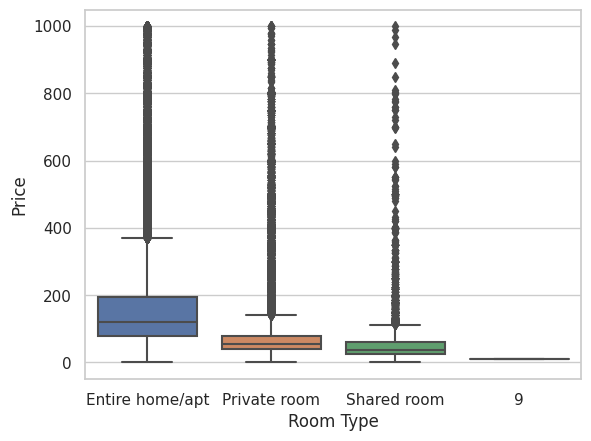

In [237]:
sns.boxplot(x='Room Type', y='Price', data=df)

Se elimina la row con el valor "9" en esta columna ya que es 1 sola


In [238]:
df = df.drop(df[df['Room Type'] == '9'].index)

In [239]:
mapeo = {'Shared room': 1, 'Private room': 2,'Entire home/apt':3}
df['Room Type'] = df['Room Type'].map(mapeo)

### Bed type

In [240]:
df['Bed Type'].value_counts(normalize=True)

Real Bed         0.965932
Pull-out Sofa    0.019989
Futon            0.007285
Couch            0.004095
Airbed           0.002700
Name: Bed Type, dtype: float64

Se elimina esta variable ya que 97% de las filas contiene el mismo valor

In [241]:
df=df.drop(['Bed Type'],axis=1)

### Experiences

In [242]:
df['Experiences Offered'].value_counts(normalize=True)

none        0.993536
business    0.002133
social      0.001876
family      0.001600
romantic    0.000855
Name: Experiences Offered, dtype: float64

Se elimina esta variable ya que 99% de las filas contiene el mismo valor

In [243]:
df=df.drop(['Experiences Offered'],axis=1)

### Amenities

In [244]:
df['Amenities'].head()

0    TV,Cable TV,Wireless Internet,Kitchen,Elevator...
1    TV,Internet,Wireless Internet,Air conditioning...
2    TV,Wireless Internet,Air conditioning,Breakfas...
3    Breakfast,Elevator in building,Heating,Washer,...
4    Internet,Wireless Internet,Air conditioning,Ki...
Name: Amenities, dtype: object

Generamos un split para visualizar la cantidad diferente de valores de amenites que existen.

In [245]:
amenities_split = df['Amenities'].str.split(',')
all_amenities = [item for sublist in amenities_split.dropna() for item in sublist]
unique_amenities = set(all_amenities)

In [246]:
unique_amenities

{'24-Hour Check-in',
 '24-hour check-in',
 'Accessible-height bed',
 'Accessible-height toilet',
 'Air Conditioning',
 'Air conditioning',
 'BBQ grill',
 'Baby bath',
 'Baby monitor',
 'Babysitter recommendations',
 'Bathtub',
 'Beach essentials',
 'Beachfront',
 'Bed linens',
 'Breakfast',
 'Buzzer/Wireless Intercom',
 'Buzzer/wireless intercom',
 'Cable TV',
 'Carbon Monoxide Detector',
 'Carbon monoxide detector',
 'Cat(s)',
 'Changing table',
 'Children’s books and toys',
 'Children’s dinnerware',
 'Cleaning before checkout',
 'Coffee maker',
 'Cooking basics',
 'Crib',
 'Disabled parking spot',
 'Dishes and silverware',
 'Dishwasher',
 'Dog(s)',
 'Doorman',
 'Doorman Entry',
 'Dryer',
 'EV charger',
 'Elevator in Building',
 'Elevator in building',
 'Essentials',
 'Ethernet connection',
 'Extra pillows and blankets',
 'Family/Kid Friendly',
 'Family/kid friendly',
 'Fire Extinguisher',
 'Fire extinguisher',
 'Fireplace guards',
 'Firm matress',
 'Firm mattress',
 'First Aid Kit',


Generamos variales dummies para las variables 'Pool', 'Hot tub', 'Pets Allowed', ya que consideramos que son 3 caracteristicas importantes de alojamiento que pueden incidir en el precio final.

In [247]:
df['Has_Pool'] = df['Amenities'].str.contains('Pool')
df['Amenities'] = df['Amenities'].str.replace('Hot tub', 'Hot_Tub')
df['Amenities'] = df['Amenities'].str.replace('Pets allowed', 'Pets Allowed')
df['Hot_Tub'] = df['Amenities'].str.contains('Hot_Tub')
df['Pets_Allowed'] = df['Amenities'].str.contains('Pets Allowed')

In [248]:
df['Has_Pool'].value_counts(normalize=True)

False    0.926308
True     0.073692
Name: Has_Pool, dtype: float64

In [249]:
df['Hot_Tub'].value_counts(normalize=True)

False    0.946051
True     0.053949
Name: Hot_Tub, dtype: float64

In [250]:
df['Pets_Allowed'].value_counts(normalize=True)

False    0.865064
True     0.134936
Name: Pets_Allowed, dtype: float64

<Axes: xlabel='Pets_Allowed', ylabel='Price'>

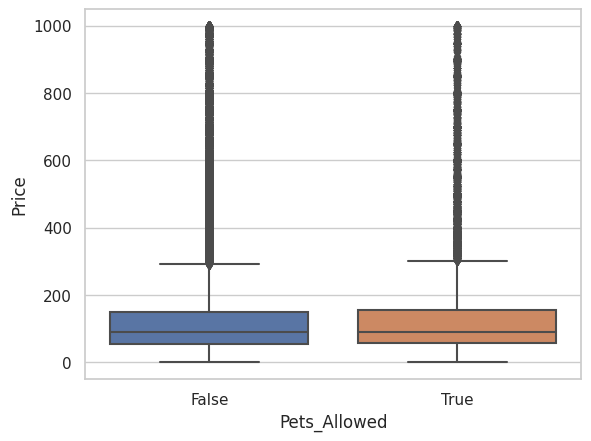

In [251]:
sns.boxplot(x='Pets_Allowed', y='Price', data=df)

<Axes: xlabel='Has_Pool', ylabel='Price'>

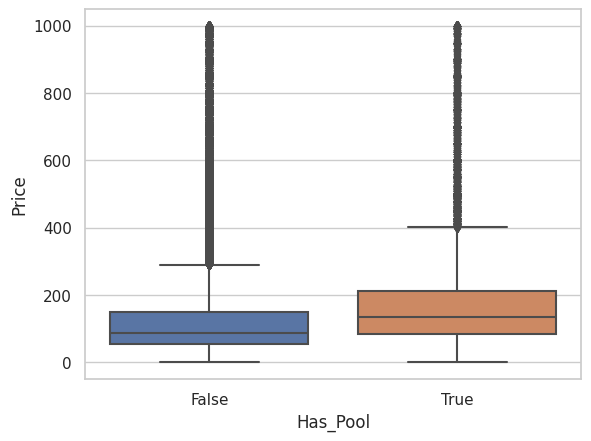

In [252]:
sns.boxplot(x='Has_Pool', y='Price', data=df)

<Axes: xlabel='Hot_Tub', ylabel='Price'>

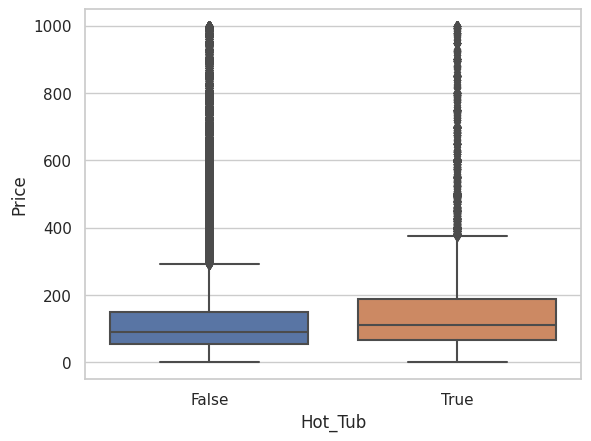

In [253]:
sns.boxplot(x='Hot_Tub', y='Price', data=df)

Se cambia la variable Amenities por las variables Dummies Has_Pool y Has_TotTub

In [254]:
df=df.drop(['Amenities','Pets_Allowed'],axis=1)

### Features

In [255]:
df['Features'].head(5)

0                Host Has Profile Pic,Instant Bookable
1               Host Has Profile Pic,Is Location Exact
2               Host Has Profile Pic,Is Location Exact
3    Host Is Superhost,Host Has Profile Pic,Is Loca...
4    Host Has Profile Pic,Is Location Exact,Instant...
Name: Features, dtype: object

Generamos un split para visualizar la cantidad diferente de valores de Features que existen.

In [256]:
features_split = df['Features'].str.split(',')
all_features = [item for sublist in features_split.dropna() for item in sublist]
unique_features = set(all_features)

In [257]:
unique_features

{'Host Has Profile Pic',
 'Host Identity Verified',
 'Host Is Superhost',
 'Instant Bookable',
 'Is Location Exact',
 'Require Guest Phone Verification',
 'Require Guest Profile Picture',
 'Requires License'}

Generamos variales dummies para las variables 'Superhost', 'Instant', 'Exact', ya que consideramos que son 3 caracteristicas importantes de Features que pueden incidir en el precio final.

In [258]:
df['Superhost'] = df['Features'].str.contains('Superhost')
df['Instant Bookable']=df['Features'].str.contains('Instant')
df['Is Location Exact']=df['Features'].str.contains('Exact')

In [259]:
df['Superhost'].value_counts(normalize=True)

False    0.885471
True     0.114529
Name: Superhost, dtype: float64

In [260]:
df['Instant Bookable'].value_counts(normalize=True)

False    0.751299
True     0.248701
Name: Instant Bookable, dtype: float64

In [261]:
df['Is Location Exact'].value_counts(normalize=True)

True     0.750294
False    0.249706
Name: Is Location Exact, dtype: float64

<Axes: xlabel='Superhost', ylabel='Price'>

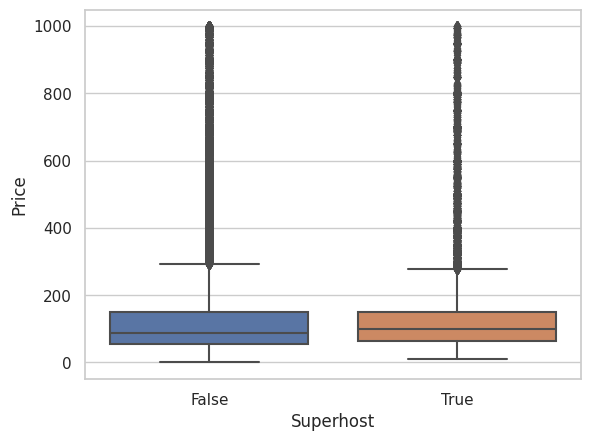

In [262]:
sns.boxplot(x='Superhost', y='Price', data=df)

<Axes: xlabel='Instant Bookable', ylabel='Price'>

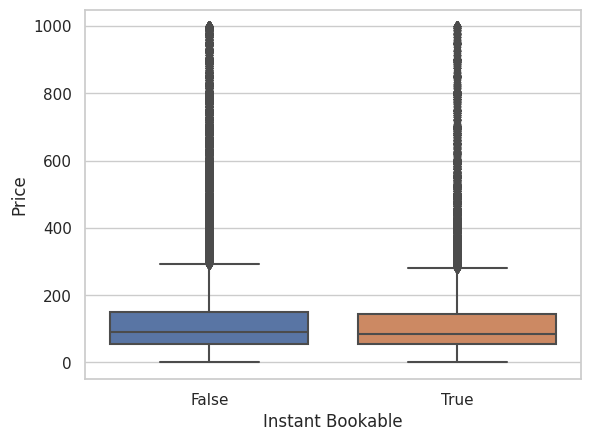

In [263]:
sns.boxplot(x='Instant Bookable', y='Price', data=df)

<Axes: xlabel='Is Location Exact', ylabel='Price'>

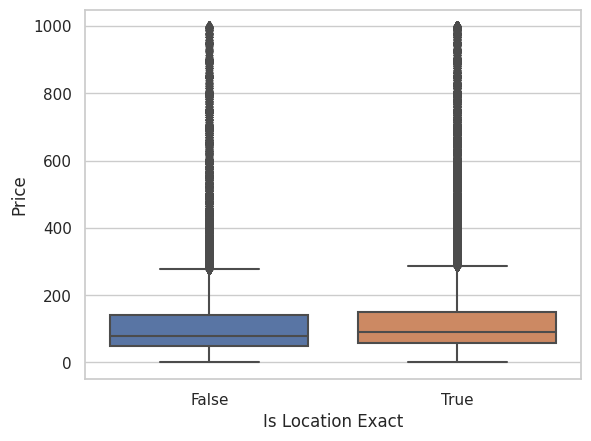

In [264]:
sns.boxplot(x='Is Location Exact', y='Price', data=df)

In [265]:
df=df.drop(['Features','Superhost','Is Location Exact','Instant Bookable'],axis=1)

Se descarta la variable Features y Superhost ya que no parecen contener información muy relevante para predecir la variable objetivo

### Property type

In [266]:
df['Property Type'].value_counts()

Apartment             232146
House                  61321
Bed & Breakfast         8066
Condominium             6778
Loft                    3963
Townhouse               3845
Other                   2114
Villa                   2046
Guesthouse              1067
Bungalow                 826
Dorm                     815
Boat                     626
Cabin                    528
Chalet                   434
Boutique hotel           354
Hostel                   278
Serviced apartment       265
Camper/RV                247
Timeshare                114
Guest suite               95
Tent                      67
Vacation home             48
Treehouse                 42
Castle                    36
Earth House               24
In-law                    24
Hut                       20
Yurt                      19
Tipi                      13
Entire Floor              11
Cave                       8
Nature lodge               8
Lighthouse                 8
Casa particular            6
Island        

In [267]:
filtered_df = df[df['Property Type'].isin(['Apartment', 'House', 'Condominium','Loft','Bed & Breakfast','Townhouse'])]

(array([0, 1, 2, 3, 4, 5]),
 [Text(0, 0, 'Apartment'),
  Text(1, 0, 'House'),
  Text(2, 0, 'Bed & Breakfast'),
  Text(3, 0, 'Condominium'),
  Text(4, 0, 'Loft'),
  Text(5, 0, 'Townhouse')])

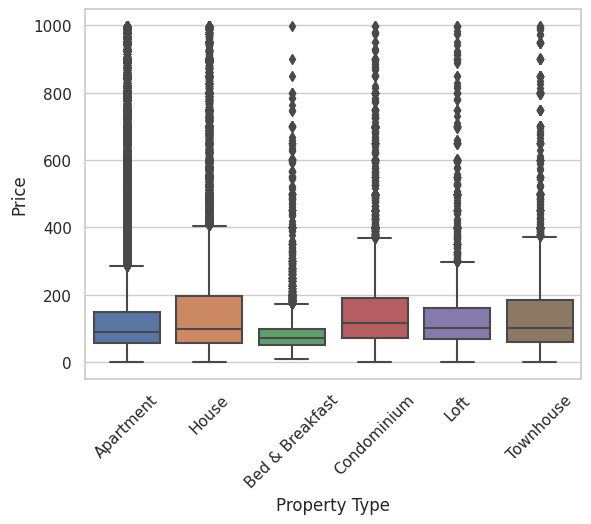

In [268]:
sns.boxplot(x='Property Type', y='Price', data=filtered_df)
plt.xticks(rotation=45)

Se decide limitar las categorias de esta variable ya que son en total 42 pero las primeras 6 acumulan el 97% de las observaciones.
En el 3% restante se decide imputar el valor Apartment ya que es el valor con mayor cantidad de observaciones (71%).

In [269]:
prop_types = ['Apartment', 'House', 'Condominium', 'Loft', 'Bed & Breakfast', 'Townhouse']
df.loc[~df['Property Type'].isin(prop_types), 'Property Type'] = 'Apartment'

In [270]:
len(df.columns)

47

### Availabilty

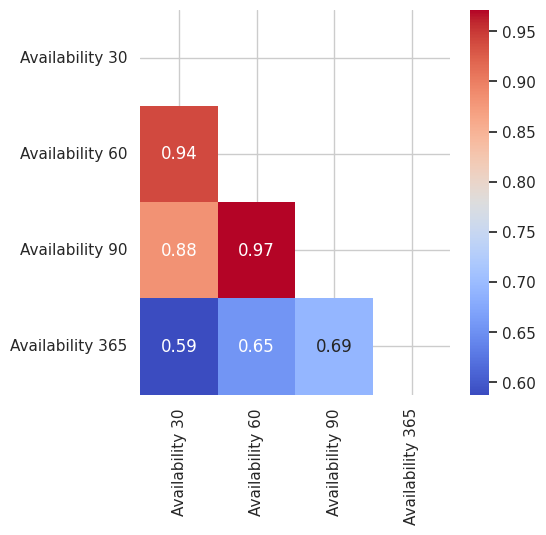

In [271]:
corr = df[availability].corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
fig, ax = plt.subplots(figsize=(5, 5))
sns.heatmap(corr, annot=True, cmap='coolwarm', ax=ax, mask=mask)
plt.show()

In [272]:
df[['Availability 60', 'Availability 90','Availability 30','Availability 365','Price']].corr()['Price']

Availability 60    -0.004711
Availability 90    -0.022040
Availability 30     0.008635
Availability 365   -0.026208
Price               1.000000
Name: Price, dtype: float64

Las columnas Availability 30,60 y 90 están altamente correlacionadas (>=0.88) por lo cual se decide analizar correlación con variable Price para elegir cuál elegir para el modelo.

Al analizar correlación con Price, notamos que ninguna de ellas tiene alta correlación con la variable objetivo.

Por lo cual se decide no utilizar ninguna de ellas.

In [273]:
df=df.drop(availability,axis=1)

### Reviews

In [274]:
reviews=['Price','Reviews per Month','Number of Reviews','First Review','Last Review','Review Scores Rating','Review Scores Accuracy','Review Scores Checkin','Review Scores Cleanliness','Review Scores Value','Review Scores Communication','Review Scores Location']

<ipython-input-275-533072ec687f>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = df[reviews].corr()


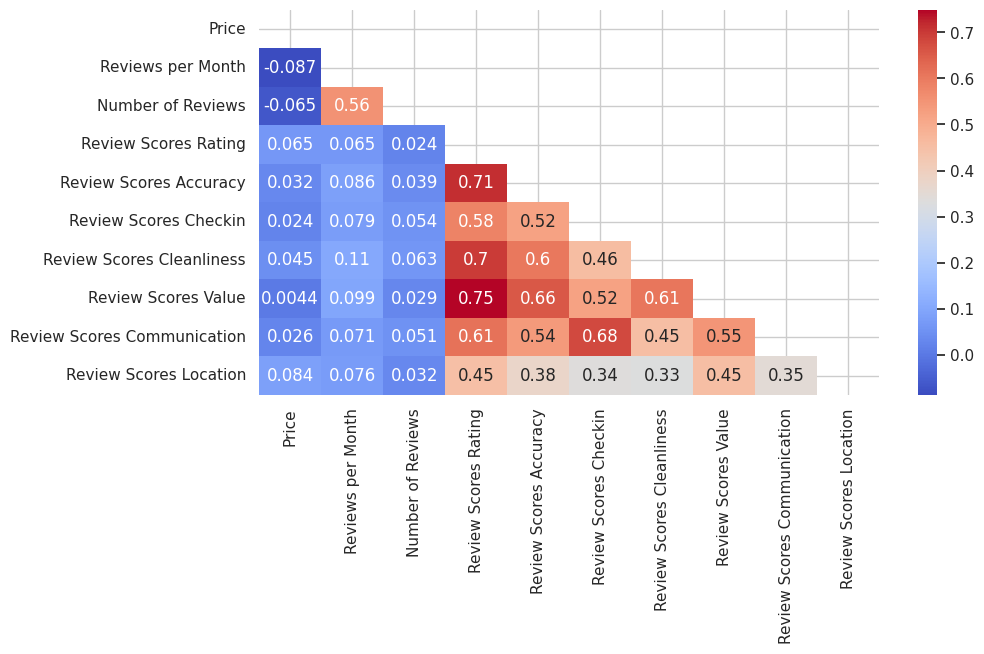

In [275]:
corr = df[reviews].corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
fig, ax = plt.subplots(figsize=(10, 5))
sns.heatmap(corr, annot=True, cmap='coolwarm', ax=ax, mask=mask)
plt.show()

In [276]:
df[reviews].corr()['Price']

<ipython-input-276-3af80103f65c>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  df[reviews].corr()['Price']


Price                          1.000000
Reviews per Month             -0.086557
Number of Reviews             -0.065420
Review Scores Rating           0.064660
Review Scores Accuracy         0.032375
Review Scores Checkin          0.023603
Review Scores Cleanliness      0.045148
Review Scores Value            0.004369
Review Scores Communication    0.026361
Review Scores Location         0.084172
Name: Price, dtype: float64

Reviews Score Rating, Scores Value, Cleanliness y Scores Accuracy están altamente correlacionadas (>0.70), se decide mantener la variable Score Rating por tener mayor correlación con la variable objetivo.

Las variables relativas al review de checkin y communication están altamente correlacionadas entre ellas (0.68) por lo cual se analiza cuál de ellas conservar. Al analizar la correlación con Price se decide no conservar ninguna de ellas ya que ambas son bajas (~0.02)

In [277]:
cols_elim5=['Review Scores Accuracy','Review Scores Checkin','Review Scores Cleanliness','Review Scores Value','Review Scores Communication']

In [278]:
df=df.drop(cols_elim5, axis=1)

First/Last Review

In [279]:
null_info[null_info['Col'].isin(['First Review','Last Review'])]

,Col,Cant_Nulos,Share_nulos
First Review,First Review,79304,24.304983
Last Review,Last Review,79241,24.285675


Dado que ambas variables tienen un alto share de valores nulos (casi 25%) se decide eliminarlas.

In [280]:
df=df.drop(['First Review','Last Review'], axis=1)

In [281]:
len(df.columns)

36

In [282]:
hoy = datetime.now()
df['Last Scraped'] = pd.to_datetime(df['Last Scraped'])
df['Last Scraped_Days'] = (hoy - df['Last Scraped']).dt.days

In [283]:
df[['Last Scraped_Days','Price']].corr()['Price']

Last Scraped_Days   -0.02173
Price                1.00000
Name: Price, dtype: float64

In [284]:
df=df.drop(['Last Scraped_Days','Last Scraped'],axis=1)

In [285]:
hoy = datetime.now()
df['Calendar last Scraped'] = pd.to_datetime(df['Calendar last Scraped'])
df['Calendar_Last_Scraped_Days'] = (hoy - df['Calendar last Scraped']).dt.days

In [286]:
df[['Calendar_Last_Scraped_Days','Price']].corr()['Price']

Calendar_Last_Scraped_Days   -0.021815
Price                         1.000000
Name: Price, dtype: float64

In [287]:
df=df.drop(['Calendar_Last_Scraped_Days','Calendar last Scraped'],axis=1)

### Host

In [288]:
df[host].head()

,Host Response Time,Host Since,Host Verifications,Host Response Rate
0,within an hour,2015-12-10,"email,phone,reviews",100.0
1,within a few hours,2015-11-29,phone,100.0
2,NaN,2015-10-26,"email,phone",NaN
3,within an hour,2015-05-10,"email,phone,reviews",100.0
4,within an hour,2016-07-27,"phone,reviews",70.0


In [289]:
null_info[null_info['Col'].isin(host)]

,Col,Cant_Nulos,Share_nulos
Host Since,Host Since,317,0.097154
Host Response Time,Host Response Time,75441,23.121056
Host Response Rate,Host Response Rate,75442,23.121362
Host Verifications,Host Verifications,536,0.164273


In [290]:
hoy = datetime.now()
df['Host Since'] = pd.to_datetime(df['Host Since'])
df['Host Since_Days'] = (hoy - df['Host Since']).dt.days

In [291]:
df[['Host Since_Days','Price']].corr()

,Host Since_Days,Price
Host Since_Days,1.000000,0.028971
Price,0.028971,1.000000


In [292]:
df= df.drop('Host Since_Days', axis=1)

Se decide no utilizar ninguna de las variables del grupo "Host" por su alta cantidad de valores nulos y por su baja correlación con la variable objetivo.

In [293]:
df=df.drop(host, axis=1)

### Listings

In [294]:
listings=['Calculated host listings count','Host Listings Count','Host Total Listings Count','Price']

In [295]:
df[listings].corr()['Price']

Calculated host listings count    0.041223
Host Listings Count               0.051946
Host Total Listings Count         0.051946
Price                             1.000000
Name: Price, dtype: float64

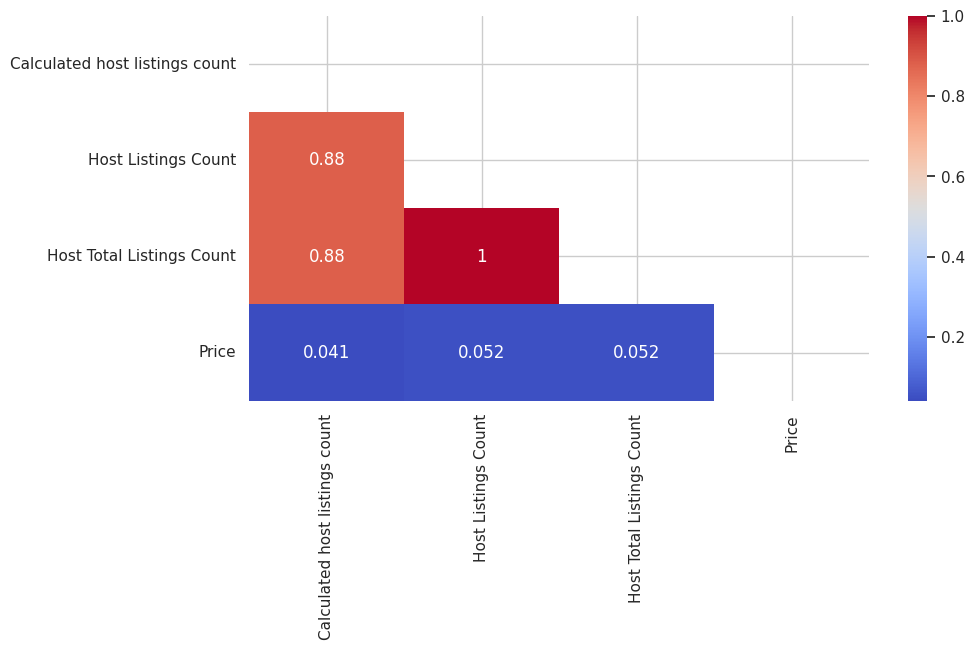

In [296]:
corr = df[listings].corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
fig, ax = plt.subplots(figsize=(10, 5))
sns.heatmap(corr, annot=True, cmap='coolwarm', ax=ax, mask=mask)
plt.show()

In [297]:
null_info[null_info['Col'].isin(listings)]

,Col,Cant_Nulos,Share_nulos
Host Listings Count,Host Listings Count,316,0.096847
Host Total Listings Count,Host Total Listings Count,317,0.097154
Calculated host listings count,Calculated host listings count,598,0.183274
Price,Price,0,0.000000


In [298]:
df=df.drop(['Calculated host listings count','Host Total Listings Count'], axis=1)

Las variables Host Total Listings Count y Host Listings Count son prácticamente la misma por lo cual se elimina una de ellas (correlación 1).

También se elimina la variable Calculated host listings count por alta correlación con Host Listings Count y tener mayor cantidad de nulos asi como menor correlación con la variable objetivo.


### Info geográfica

In [299]:
geo=['Latitude','Longitude','Price','Street','Country Code','City','State','Zipcode','Smart Location','Neighbourhood Cleansed','Host Neighbourhood','Market','Host Location']

In [300]:
df[geo].head(10)

,Latitude,Longitude,Price,Street,Country Code,City,State,Zipcode,Smart Location,Neighbourhood Cleansed,Host Neighbourhood,Market,Host Location
0,51.219388,4.403444,159.0,"Antwerp, Flanders, Belgium",BE,Antwerp,Flanders,NaN,"Antwerp, Belgium",Historisch Centrum,NaN,Antwerp,"Antwerp, Flanders, Belgium"
1,34.189269,-118.419935,49.0,"Valley Glen, Los Angeles, CA 91401, United States",US,Los Angeles,CA,91401,"Los Angeles, CA",Valley Glen,Valley Glen,Los Angeles,"Los Angeles, California, United States"
2,41.908596,12.493518,75.0,"Ludovisi, Roma, Lazio 00187, Italy",IT,Roma,Lazio,00187,"Roma, Italy",I Centro Storico,Ludovisi,Rome,"Rome, Lazio, Italy"
3,41.883985,12.499185,55.0,"Monti, Roma, Lazio 00184, Italy",IT,Roma,Lazio,00184,"Roma, Italy",I Centro Storico,Monti,Rome,"Rome, Lazio, Italy"
4,40.720983,-73.997836,177.0,"Soho, New York, NY 10013, United States",US,New York,NY,10013,"New York, NY",SoHo,Soho,New York,"New York, New York, United States"
5,48.859354,2.308245,47.0,"Tour Eiffel - Champ de Mars, Paris, Île-de-Fra...",FR,Paris,Île-de-France,75007,"Paris, France",Palais-Bourbon,Tour Eiffel - Champ de Mars,Paris,"Paris, Île-de-France, France"
6,48.879162,2.371675,70.0,"Buttes-Chaumont - Belleville, Paris, Île-de-Fr...",FR,Paris,Île-de-France,75010,"Paris, France",Buttes-Chaumont,Buttes-Chaumont - Belleville,Paris,"Paris, Île-de-France, France"
7,40.816603,-73.937020,57.0,"Harlem, New York, NY 10037, United States",US,New York,NY,10037,"New York, NY",Harlem,Harlem,New York,"New York, New York, United States"
8,-37.809188,144.986107,275.0,"East Melbourne, East Melbourne, VIC 3002, Aust...",AU,East Melbourne,VIC,3002,"East Melbourne, Australia",Yarra,East Melbourne,Melbourne,"Victoria, Australia"
9,51.430897,-0.119824,30.0,"Harborough Road, London, SW16, United Kingdom",GB,London,NaN,SW16,"London, United Kingdom",Lambeth,Streatham,London,GB


Las columnas que son texto se pasan todas a mayúsculas para evitar tener categorías duplicadas (ej "NY, ny")

In [301]:
df['Smart Location']=df['Smart Location'].str.upper()
df['Neighbourhood Cleansed']=df['Neighbourhood Cleansed'].str.upper()

In [302]:
df[geo].head(10)

,Latitude,Longitude,Price,Street,Country Code,City,State,Zipcode,Smart Location,Neighbourhood Cleansed,Host Neighbourhood,Market,Host Location
0,51.219388,4.403444,159.0,"Antwerp, Flanders, Belgium",BE,Antwerp,Flanders,NaN,"ANTWERP, BELGIUM",HISTORISCH CENTRUM,NaN,Antwerp,"Antwerp, Flanders, Belgium"
1,34.189269,-118.419935,49.0,"Valley Glen, Los Angeles, CA 91401, United States",US,Los Angeles,CA,91401,"LOS ANGELES, CA",VALLEY GLEN,Valley Glen,Los Angeles,"Los Angeles, California, United States"
2,41.908596,12.493518,75.0,"Ludovisi, Roma, Lazio 00187, Italy",IT,Roma,Lazio,00187,"ROMA, ITALY",I CENTRO STORICO,Ludovisi,Rome,"Rome, Lazio, Italy"
3,41.883985,12.499185,55.0,"Monti, Roma, Lazio 00184, Italy",IT,Roma,Lazio,00184,"ROMA, ITALY",I CENTRO STORICO,Monti,Rome,"Rome, Lazio, Italy"
4,40.720983,-73.997836,177.0,"Soho, New York, NY 10013, United States",US,New York,NY,10013,"NEW YORK, NY",SOHO,Soho,New York,"New York, New York, United States"
5,48.859354,2.308245,47.0,"Tour Eiffel - Champ de Mars, Paris, Île-de-Fra...",FR,Paris,Île-de-France,75007,"PARIS, FRANCE",PALAIS-BOURBON,Tour Eiffel - Champ de Mars,Paris,"Paris, Île-de-France, France"
6,48.879162,2.371675,70.0,"Buttes-Chaumont - Belleville, Paris, Île-de-Fr...",FR,Paris,Île-de-France,75010,"PARIS, FRANCE",BUTTES-CHAUMONT,Buttes-Chaumont - Belleville,Paris,"Paris, Île-de-France, France"
7,40.816603,-73.937020,57.0,"Harlem, New York, NY 10037, United States",US,New York,NY,10037,"NEW YORK, NY",HARLEM,Harlem,New York,"New York, New York, United States"
8,-37.809188,144.986107,275.0,"East Melbourne, East Melbourne, VIC 3002, Aust...",AU,East Melbourne,VIC,3002,"EAST MELBOURNE, AUSTRALIA",YARRA,East Melbourne,Melbourne,"Victoria, Australia"
9,51.430897,-0.119824,30.0,"Harborough Road, London, SW16, United Kingdom",GB,London,NaN,SW16,"LONDON, UNITED KINGDOM",LAMBETH,Streatham,London,GB


## País

In [303]:
df['Country Code'].value_counts()

US    88605
GB    40854
FR    37975
ES    30777
AU    26828
IT    22180
CA    20509
DE    13739
DK    11143
NL    10168
AT     5309
BE     4970
IE     4576
HK     3575
GR     3441
CH     1596
CN       36
MX        2
It        1
UY        1
VU        1
Name: Country Code, dtype: int64

Se decide eliminar los países que tienen menos de 1000 observaciones para que el modelo performe mejor.

In [304]:
df = df[~df['Country Code'].isin(['CN', 'MX', 'It','UY','VU'])]

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15]),
 [Text(0, 0, 'BE'),
  Text(1, 0, 'US'),
  Text(2, 0, 'IT'),
  Text(3, 0, 'FR'),
  Text(4, 0, 'AU'),
  Text(5, 0, 'GB'),
  Text(6, 0, 'CA'),
  Text(7, 0, 'ES'),
  Text(8, 0, 'DE'),
  Text(9, 0, 'IE'),
  Text(10, 0, 'DK'),
  Text(11, 0, 'NL'),
  Text(12, 0, 'GR'),
  Text(13, 0, 'AT'),
  Text(14, 0, 'HK'),
  Text(15, 0, 'CH')])

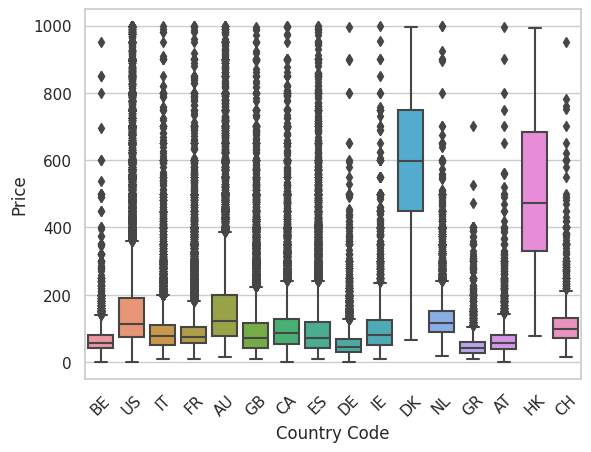

In [305]:
sns.boxplot(x='Country Code', y='Price', data=df)
plt.xticks(rotation=45)

In [306]:
null_info[null_info['Col'].isin(geo)]

,Col,Cant_Nulos,Share_nulos
Host Location,Host Location,1486,0.455427
Host Neighbourhood,Host Neighbourhood,82080,25.155768
Street,Street,0,0.000000
Neighbourhood Cleansed,Neighbourhood Cleansed,0,0.000000
City,City,283,0.086733
State,State,31295,9.591249
Zipcode,Zipcode,12472,3.822402
Market,Market,3615,1.107920
Smart Location,Smart Location,1,0.000306
Country Code,Country Code,1,0.000306


Se pasan las columnas a códigos para poder calcular correlación con Price

In [307]:
paises_unicos = df['Country Code'].unique()
codigo_pais = {pais: codigo for codigo, pais in enumerate(paises_unicos)}
df['Country_Code'] = df['Country Code'].map(codigo_pais)

In [308]:
smart_loc_unico = df['Smart Location'].unique()
codigo_loc = {loc: codigo for codigo, loc in enumerate(smart_loc_unico)}
df['Smart_Loc_Code'] = df['Smart Location'].map(codigo_loc)

In [309]:
barrio_unico = df['Neighbourhood Cleansed'].unique()
barrio = {bar: codigo for codigo, bar in enumerate(barrio_unico)}
df['Barrio_Code'] = df['Neighbourhood Cleansed'].map(barrio)

In [310]:
city = df['City'].unique()
city_ = {bar: codigo for codigo, bar in enumerate(city)}
df['City_Code'] = df['City'].map(city_)

In [311]:
geo2=['Smart_Loc_Code','Country_Code','Barrio_Code','City_Code','Zipcode','Price']

Correlación de País, Smart Location (Pais+Ciudad) y Barrio con Price

In [312]:
df[geo2].corr()['Price']

<ipython-input-312-ad381f35d343>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  df[geo2].corr()['Price']


Smart_Loc_Code    0.024234
Country_Code      0.153133
Barrio_Code      -0.096683
City_Code         0.025801
Price             1.000000
Name: Price, dtype: float64

Barrios: Notamos que hay mucha cantidad de Barrios distintos, algunos con muy pocas observaciones. Lo mismo se aplica a Estado y Zipcode.

Considerando esto En principio se mantiene unicamente el dato del pais, al evaluar los resultados del modelo en caso que sea necesario se sumarán otras variables.

In [313]:
df[df['Country_Code']==2]['Neighbourhood Cleansed'].value_counts()

I CENTRO STORICO              8159
VII SAN GIOVANNI/CINECITTÀ    1565
II PARIOLI/NOMENTANO          1425
XIII AURELIA                  1230
TRENTINO                      1096
                              ... 
ISOLA SAN GIORGIO IN ALGA        1
ASSEGGIANO                       1
CAMPALTO BAGARON                 1
DESE                             1
CAMPALTO CEP                     1
Name: Neighbourhood Cleansed, Length: 71, dtype: int64

In [314]:
geo=['Smart_Loc_Code','City_Code','Barrio_Code','Street','Country Code','City','State','Zipcode','Smart Location','Neighbourhood Cleansed','Host Neighbourhood','Market','Host Location']

In [315]:
df=df.drop(geo, axis=1)

## Preparación final de los datos

 One-hot-encoding, dummies, Datos faltantes, estandarización, correlación con variable objetivo, úñtimo check de correlación entre ellas

In [316]:
df.columns

Index(['id', 'Host Listings Count', 'Latitude', 'Longitude', 'Property Type',
       'Room Type', 'Accommodates', 'Bathrooms', 'Guests Included',
       'Extra People', 'Number of Reviews', 'Review Scores Rating',
       'Review Scores Location', 'Cancellation Policy', 'Reviews per Month',
       'Price', 'Has_Pool', 'Hot_Tub', 'Country_Code'],
      dtype='object')

### Imputación de valores nulos

In [317]:
columnas_con_nulos = df.columns[df.isnull().any()]

for col in columnas_con_nulos:
    valor_mas_frecuente = df[col].mode().iloc[0]
    porcentaje_nulos = (df[col].isnull().sum() / len(df)) * 100
    porcentaje_valor_mas_frecuente = (df[col].value_counts()[valor_mas_frecuente] / len(df)) * 100
    print(f"{col} tiene {porcentaje_nulos:.2f}% nulos, el valor más frecuente es {valor_mas_frecuente}, y representa {porcentaje_valor_mas_frecuente:.2f}% de todas las observaciones.")

Host Listings Count tiene 0.10% nulos, el valor más frecuente es 1.0, y representa 58.53% de todas las observaciones.
Accommodates tiene 0.01% nulos, el valor más frecuente es 2.0, y representa 43.13% de todas las observaciones.
Bathrooms tiene 0.30% nulos, el valor más frecuente es 1.0, y representa 76.88% de todas las observaciones.
Extra People tiene 0.00% nulos, el valor más frecuente es 0.0, y representa 59.08% de todas las observaciones.
Review Scores Rating tiene 25.47% nulos, el valor más frecuente es 100.0, y representa 19.12% de todas las observaciones.
Review Scores Location tiene 25.70% nulos, el valor más frecuente es 10.0, y representa 44.86% de todas las observaciones.
Reviews per Month tiene 24.30% nulos, el valor más frecuente es 1.0, y representa 1.88% de todas las observaciones.
Has_Pool tiene 0.88% nulos, el valor más frecuente es False, y representa 91.81% de todas las observaciones.
Hot_Tub tiene 0.88% nulos, el valor más frecuente es False, y representa 93.77% de

### Imputación de valores nulos

Se utiliza el valor más frecuente en todos los casos para imputar los valores nulos considerando que corresponde un alto porcentaje del total de observaciones en todos los casos.

Accomodates es el unico caso donde el valor mas frecuente representa menos del 50% de las observaciones, pero dado que son solo 42 observaciones con valores nulos, se entiende que no ocasionará problemas en el modelo

In [318]:
df['Hot_Tub'].fillna(False, inplace=True)
df['Has_Pool'].fillna(False, inplace=True)
df['Bathrooms'].fillna(1,inplace=True)
df['Host Listings Count'].fillna(1,inplace=True)
df['Accommodates'].fillna(2,inplace=True)
df['Extra People'].fillna(0,inplace=True)

In [319]:
df.isnull().sum()

id                            0
Host Listings Count           0
Latitude                      0
Longitude                     0
Property Type                 0
Room Type                     0
Accommodates                  0
Bathrooms                     0
Guests Included               0
Extra People                  0
Number of Reviews             0
Review Scores Rating      83100
Review Scores Location    83837
Cancellation Policy           0
Reviews per Month         79277
Price                         0
Has_Pool                      0
Hot_Tub                       0
Country_Code                  0
dtype: int64

In [320]:
df=df.drop(['Review Scores Rating','Review Scores Location','Reviews per Month'],axis=1)

In [321]:
df.head()

,id,Host Listings Count,Latitude,Longitude,Property Type,Room Type,Accommodates,Bathrooms,Guests Included,Extra People,Number of Reviews,Cancellation Policy,Price,Has_Pool,Hot_Tub,Country_Code
0,0,2.0,51.219388,4.403444,Apartment,3,6.0,1.0,6.0,25.0,9.0,6,159.0,False,False,0
1,1,1.0,34.189269,-118.419935,House,2,2.0,1.0,1.0,0.0,0.0,2,49.0,False,False,1
2,2,1.0,41.908596,12.493518,Apartment,2,2.0,1.0,1.0,0.0,0.0,1,75.0,False,True,2
3,3,1.0,41.883985,12.499185,Apartment,2,2.0,1.0,1.0,0.0,55.0,3,55.0,False,False,2
4,4,2.0,40.720983,-73.997836,Apartment,3,2.0,1.0,2.0,20.0,28.0,6,177.0,False,False,1


In [322]:
df = pd.get_dummies(df, columns=['Property Type'], drop_first=True)
df = pd.get_dummies(df, columns=['Has_Pool'], drop_first=True)
df = pd.get_dummies(df, columns=['Hot_Tub'], drop_first=True)

In [323]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 326245 entries, 0 to 326286
Data columns (total 20 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   id                             326245 non-null  int64  
 1   Host Listings Count            326245 non-null  float64
 2   Latitude                       326245 non-null  float64
 3   Longitude                      326245 non-null  float64
 4   Room Type                      326245 non-null  int64  
 5   Accommodates                   326245 non-null  float64
 6   Bathrooms                      326245 non-null  float64
 7   Guests Included                326245 non-null  float64
 8   Extra People                   326245 non-null  float64
 9   Number of Reviews              326245 non-null  float64
 10  Cancellation Policy            326245 non-null  int64  
 11  Price                          326245 non-null  float64
 12  Country_Code                  

In [324]:
features=[col for col in df.columns if col != 'id']
df[features].corr()['Price']

Host Listings Count              0.051957
Latitude                        -0.066953
Longitude                        0.049467
Room Type                        0.301767
Accommodates                     0.374042
Bathrooms                        0.260150
Guests Included                  0.193094
Extra People                     0.274735
Number of Reviews               -0.065386
Cancellation Policy              0.096834
Price                            1.000000
Country_Code                     0.153133
Property Type_Bed & Breakfast   -0.054538
Property Type_Condominium        0.015955
Property Type_House              0.063074
Property Type_Loft               0.001125
Property Type_Townhouse          0.009058
Has_Pool_True                    0.088011
Hot_Tub_True                     0.028203
Name: Price, dtype: float64

In [325]:
df=df.drop('Property Type_Townhouse',axis=1)

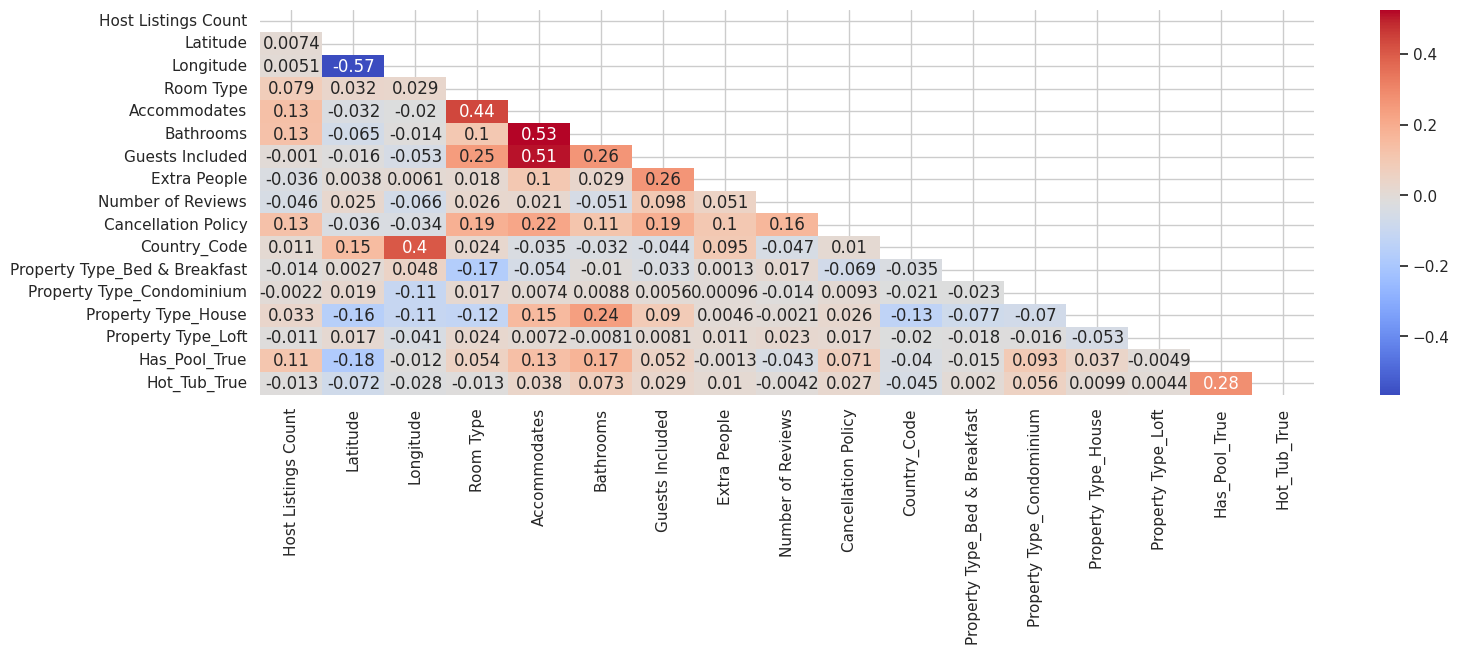

In [326]:
features=[col for col in df.columns if col != 'id']
features=[col for col in features if col != 'Price']

corr = df[features].corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
fig, ax = plt.subplots(figsize=(17, 5))
sns.heatmap(corr, annot=True, cmap='coolwarm', ax=ax, mask=mask)
plt.show()

In [327]:
df[features].isnull().sum()

Host Listings Count              0
Latitude                         0
Longitude                        0
Room Type                        0
Accommodates                     0
Bathrooms                        0
Guests Included                  0
Extra People                     0
Number of Reviews                0
Cancellation Policy              0
Country_Code                     0
Property Type_Bed & Breakfast    0
Property Type_Condominium        0
Property Type_House              0
Property Type_Loft               0
Has_Pool_True                    0
Hot_Tub_True                     0
dtype: int64

### Escalado de variables

Dado que tenemos variables con diferentes escalas (ejemplo : Baños y Number of Reviews), se decide escalar para que la performance del modelo sea mejor.



In [328]:
df.head()

,id,Host Listings Count,Latitude,Longitude,Room Type,Accommodates,Bathrooms,Guests Included,Extra People,Number of Reviews,Cancellation Policy,Price,Country_Code,Property Type_Bed & Breakfast,Property Type_Condominium,Property Type_House,Property Type_Loft,Has_Pool_True,Hot_Tub_True
0,0,2.0,51.219388,4.403444,3,6.0,1.0,6.0,25.0,9.0,6,159.0,0,0,0,0,0,0,0
1,1,1.0,34.189269,-118.419935,2,2.0,1.0,1.0,0.0,0.0,2,49.0,1,0,0,1,0,0,0
2,2,1.0,41.908596,12.493518,2,2.0,1.0,1.0,0.0,0.0,1,75.0,2,0,0,0,0,0,1
3,3,1.0,41.883985,12.499185,2,2.0,1.0,1.0,0.0,55.0,3,55.0,2,0,0,0,0,0,0
4,4,2.0,40.720983,-73.997836,3,2.0,1.0,2.0,20.0,28.0,6,177.0,1,0,0,0,0,0,0


In [331]:
var_escalar = ['Host Listings Count','Accommodates','Number of Reviews','Bathrooms','Extra People','Guests Included','Cancellation Policy','Country_Code','Room Type','Latitude','Longitude']
scaler = StandardScaler()
df[var_escalar] = scaler.fit_transform(df[var_escalar])

In [332]:
df.head()

,id,Host Listings Count,Latitude,Longitude,Room Type,Accommodates,Bathrooms,Guests Included,Extra People,Number of Reviews,Cancellation Policy,Price,Country_Code,Property Type_Bed & Breakfast,Property Type_Condominium,Property Type_House,Property Type_Loft,Has_Pool_True,Hot_Tub_True
0,0,-0.132086,0.575045,0.281640,0.743134,1.339686,-0.415924,3.731894,0.508341,-0.242541,1.129569,159.0,-1.312806,0,0,0,0,0,0
1,1,-0.149515,-0.168278,-1.470675,-1.167903,-0.623711,-0.415924,-0.451872,-0.415510,-0.520720,-1.191680,49.0,-1.018573,0,0,1,0,0,0
2,2,-0.149515,0.168652,0.397061,-1.167903,-0.623711,-0.415924,-0.451872,-0.415510,-0.520720,-1.771993,75.0,-0.724340,0,0,0,0,0,1
3,3,-0.149515,0.167578,0.397141,-1.167903,-0.623711,-0.415924,-0.451872,-0.415510,1.179263,-0.611368,55.0,-0.724340,0,0,0,0,0,0
4,4,-0.132086,0.116815,-0.836907,0.743134,-0.623711,-0.415924,0.384882,0.323571,0.344726,1.129569,177.0,-1.018573,0,0,0,0,0,0


In [333]:
df.corr()['Price']

id                               0.001705
Host Listings Count              0.051957
Latitude                        -0.066953
Longitude                        0.049467
Room Type                        0.301767
Accommodates                     0.374042
Bathrooms                        0.260150
Guests Included                  0.193094
Extra People                     0.274735
Number of Reviews               -0.065386
Cancellation Policy              0.096834
Price                            1.000000
Country_Code                     0.153133
Property Type_Bed & Breakfast   -0.054538
Property Type_Condominium        0.015955
Property Type_House              0.063074
Property Type_Loft               0.001125
Has_Pool_True                    0.088011
Hot_Tub_True                     0.028203
Name: Price, dtype: float64

## 4. Modelo Baseline

### 4.1 Seleccionar características relevantes

In [334]:
target = 'Price'
features = [c for c in df.columns if c != 'id' and c != 'Price']
features

['Host Listings Count',
 'Latitude',
 'Longitude',
 'Room Type',
 'Accommodates',
 'Bathrooms',
 'Guests Included',
 'Extra People',
 'Number of Reviews',
 'Cancellation Policy',
 'Country_Code',
 'Property Type_Bed & Breakfast',
 'Property Type_Condominium',
 'Property Type_House',
 'Property Type_Loft',
 'Has_Pool_True',
 'Hot_Tub_True']

In [335]:
X = df[features]
y = df[target]

### 4.2 Dividir los datos en conjuntos de entrenamiento y prueba

In [336]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### 4.3 Definir el modelo

In [337]:
from tensorflow.keras.layers import Dropout
from tensorflow.keras.optimizers import Adam

def get_model(neurons, optimizer, dropout):
    layers = []
    input_shape = (X_train.shape[1],)
    for n in neurons:
        layers.append(Dense(n, activation = "relu", input_shape = input_shape))
        layers.append(Dropout(dropout))
        input_shape = (n,)

    model = Sequential(layers)
    model.summary()
    model.compile(optimizer = optimizer, loss='mean_squared_error', metrics=['mae'])
    return model

In [338]:
!pip install wandb

In [339]:
import wandb

wandb.login()

#Creamos un proyecto en WandB a través de su interfaz
project = "obligatorio-deep-learning"
entity = "ort-martin"

In [340]:
import traceback
from os import sys
from tensorflow import keras
from tensorflow.keras.layers import Dense
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dropout
from keras.callbacks import EarlyStopping

def run_train():
    try:
        with wandb.init(config = None, project = project, entity=entity):
            # initialize model
            config = wandb.config
            print(config)
            model= get_model(config.neurons, config.optimizer, config.dropout)
            tf.keras.backend.clear_session()
            wandb_callback = wandb.keras.WandbCallback()
            model.fit(X_train, y_train, epochs=config.epochs, batch_size=config.batch_size, validation_split=0.2, callbacks=[wandb_callback], max_queue_size=3, workers=2)
            print("epochs: ",config.epochs)
            print("batch_size: ",config.batch_size)
            print("neurons: ", config.neurons)
            print("optimizer: ", config.optimizer)


    except Exception as e:
        # exit gracefully, so wandb logs the problem
        print(traceback.print_exc(), file=sys.stderr)
        exit(1)

In [341]:
from tensorflow import keras

In [342]:
from tensorflow.keras import Sequential

In [343]:
#import pprint



'''sweep_config = {
'name': 'sweep_example',
'method': 'grid',
'metric': {
    'name': 'val_loss',
    'goal': 'minimize'
},
'parameters': {
    'dropout':{'value': 0.1},
    'neurons':{
        'values': [[64, 1], [64, 32, 2], [32, 2]]
        },
'optimizer': {
        'values': ['adam', 'sgd']
        },
'batch_size': {
        'values': [128, 64, 32]
        },
'epochs': {
        'values': [35, 25]
        }
}}

pprint.pprint(sweep_config)'''

"sweep_config = {\n'name': 'sweep_example',\n'method': 'grid',\n'metric': {\n    'name': 'val_loss',\n    'goal': 'minimize'\n},\n'parameters': {\n    'dropout':{'value': 0.1},\n    'neurons':{\n        'values': [[64, 1], [64, 32, 2], [32, 2]]\n        },\n'optimizer': {\n        'values': ['adam', 'sgd']\n        },\n'batch_size': {\n        'values': [128, 64, 32]\n        },\n'epochs': {\n        'values': [35, 25]\n        }\n}}\n\npprint.pprint(sweep_config)"

In [344]:
#sweep_id = wandb.sweep(sweep_config, project = project, entity = entity)

In [345]:
#wandb.agent(sweep_id, function = run_train, count=36, project = project, entity = entity)

### 4.4 Entrenar

### Entrenamos con los mejores hiperparámetros

In [346]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# Definir el optimizador y las capas ocultas
opt = Adam(clipvalue=0.0, learning_rate=0.001)

model = Sequential()
model.add(Dense(64, activation='relu', input_shape=(X_train.shape[1],)))
model.add(Dropout(0.1))

# Hidden layer with dropout
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.1))

# Output layer
model.add(Dense(2, activation='relu'))
model.add(Dropout(0.1))

model.compile(loss='mean_squared_error', optimizer=opt, metrics=['mae'])

early_stopping = EarlyStopping(monitor='val_loss', patience=3, verbose=1, restore_best_weights=True)

history = model.fit(X_train, y_train, epochs=30, batch_size=128, callbacks=[early_stopping], validation_split=0.2)





Epoch 1/30
1632/1632 [==============================] - 18s 10ms/step - loss: 19034.4102 - mae: 82.0194 - val_loss: 13564.1660 - val_mae: 64.3387
Epoch 2/30
1632/1632 [==============================] - 18s 11ms/step - loss: 15572.6006 - mae: 73.5022 - val_loss: 12432.7725 - val_mae: 61.3651
Epoch 3/30
1632/1632 [==============================] - 21s 13ms/step - loss: 14616.6416 - mae: 71.2557 - val_loss: 11297.4111 - val_mae: 59.8399
Epoch 4/30
1632/1632 [==============================] - 5s 3ms/step - loss: 13779.6973 - mae: 69.3921 - val_loss: 10104.8457 - val_mae: 57.0465
Epoch 5/30
1632/1632 [==============================] - 6s 4ms/step - loss: 12607.1367 - mae: 66.1653 - val_loss: 8891.7129 - val_mae: 52.7563
Epoch 6/30
1632/1632 [==============================] - 11s 7ms/step - loss: 11378.4346 - mae: 62.4483 - val_loss: 7762.0542 - val_mae: 48.9453
Epoch 7/30
1632/1632 [==============================] - 7s 4ms/step - loss: 10693.6084 - mae: 59.8660 - val_loss: 7136.1973 - val_m

In [347]:
loss = history.history['loss']
val_loss = history.history['val_loss']
sns.set(style='whitegrid')
mae = history.history['mae']
val_mae = history.history['val_mae']

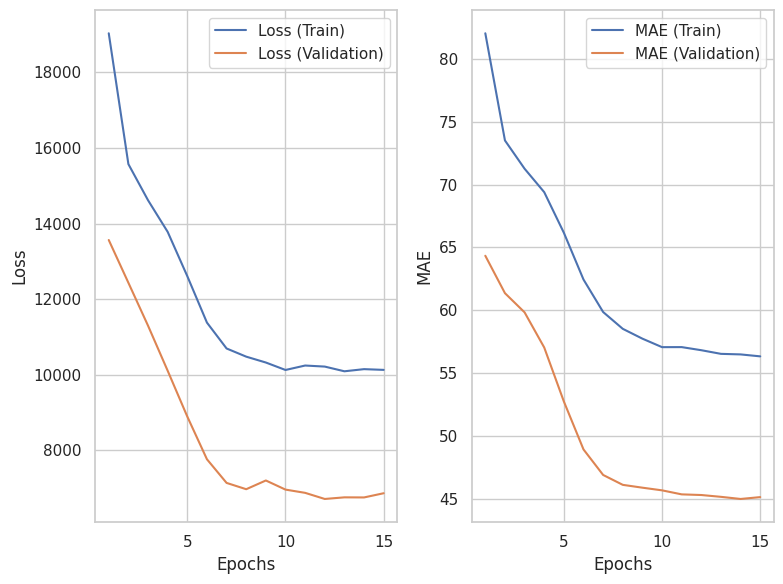

In [348]:
plt.figure(figsize=(8, 6))
plt.subplot(1, 2, 1)
sns.lineplot(x=range(1, len(loss) + 1), y=loss, label='Loss (Train)')
sns.lineplot(x=range(1, len(val_loss) + 1), y=val_loss, label='Loss (Validation)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()


plt.subplot(1, 2, 2)
sns.lineplot(x=range(1, len(mae) + 1), y=mae, label='MAE (Train)')
sns.lineplot(x=range(1, len(val_mae) + 1), y=val_mae, label='MAE (Validation)')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()

plt.tight_layout()
plt.show()


### 4.5 Evaluar en Test

In [349]:
loss, mae = model.evaluate(X_test, y_test)
print(f'Test Loss: {loss}, Test MAE: {mae}')

2040/2040 [==============================] - 3s 2ms/step - loss: 6546.0869 - mae: 44.8820
Test Loss: 6546.0869140625, Test MAE: 44.882015228271484


## 5 Generación de salida para competencia en Kaggle

In [350]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [351]:
!cp '/content/drive/MyDrive/Data/private_data_to_predict.csv' '/content/'
data_for_kaggle = pd.read_csv('private_data_to_predict.csv')

In [352]:
data_for_kaggle=data_for_kaggle.drop(cols_eliminar1, axis=1)

In [353]:
data_for_kaggle=data_for_kaggle.drop(cols_eliminar2,axis=1)

In [354]:
data_for_kaggle=data_for_kaggle.drop(cols_eliminar3,axis=1)

In [355]:
data_for_kaggle=data_for_kaggle.drop('Country',axis=1)

In [356]:
data_for_kaggle=data_for_kaggle.drop(cols_eliminar4, axis=1)

In [357]:
data_for_kaggle=data_for_kaggle.drop(['Geolocation'],axis=1)

In [358]:
data_for_kaggle=data_for_kaggle.drop(['Calendar Updated'],axis=1)

In [359]:
data_for_kaggle=data_for_kaggle.drop(['Name','Summary','Space','Description'],axis=1)

In [360]:
data_for_kaggle=data_for_kaggle.drop(['Beds','Bedrooms'],axis=1)

In [361]:
data_for_kaggle=data_for_kaggle.drop(['Minimum Nights','Maximum Nights'],axis=1)

In [362]:
canc_types = ['strict', 'flexible', 'moderate','moderate_new','strict_new','flexible_new']
data_for_kaggle.loc[~data_for_kaggle['Cancellation Policy'].isin(canc_types), 'Cancellation Policy'] = 'strict'

In [363]:
mapeo = {'flexible_new': 1, 'flexible': 2,'moderate_new':3, 'moderate':4,'strict_new':5,'strict':6}
data_for_kaggle['Cancellation Policy'] = data_for_kaggle['Cancellation Policy'].map(mapeo)

In [364]:
data_for_kaggle=data_for_kaggle.drop(data_for_kaggle[data_for_kaggle['Room Type'] == '9'].index)

In [365]:
mapeo = {'Shared room': 1, 'Private room': 2,'Entire home/apt':3}
data_for_kaggle['Room Type'] = data_for_kaggle['Room Type'].map(mapeo)

In [366]:
data_for_kaggle=data_for_kaggle.drop(['Bed Type'],axis=1)

In [367]:
data_for_kaggle=data_for_kaggle.drop(['Experiences Offered'],axis=1)

In [368]:
amenities_split = data_for_kaggle['Amenities'].str.split(',')
all_amenities = [item for sublist in amenities_split.dropna() for item in sublist]
unique_amenities = set(all_amenities)

In [369]:
data_for_kaggle['Has_Pool'] = data_for_kaggle['Amenities'].str.contains('Pool')
data_for_kaggle['Amenities'] = data_for_kaggle['Amenities'].str.replace('Hot tub', 'Hot_Tub')
data_for_kaggle['Hot_Tub'] = data_for_kaggle['Amenities'].str.contains('Hot_Tub')

In [370]:
data_for_kaggle=data_for_kaggle.drop(['Amenities'],axis=1)

In [371]:
filtered_df = data_for_kaggle[data_for_kaggle['Property Type'].isin(['Apartment', 'House', 'Condominium','Loft','Bed & Breakfast','Townhouse'])]

In [372]:
data_for_kaggle.loc[~data_for_kaggle['Property Type'].isin(prop_types), 'Property Type'] = 'Apartment'

In [373]:
data_for_kaggle=data_for_kaggle.drop(availability,axis=1)

In [374]:
data_for_kaggle=data_for_kaggle.drop(cols_elim5, axis=1)

In [375]:
data_for_kaggle=data_for_kaggle.drop(['First Review','Last Review'], axis=1)

In [376]:
data_for_kaggle=data_for_kaggle.drop(['Last Scraped'],axis=1)

In [377]:
data_for_kaggle=data_for_kaggle.drop(['Calendar last Scraped'],axis=1)

In [378]:
data_for_kaggle=data_for_kaggle.drop(host, axis=1)

In [379]:
data_for_kaggle=data_for_kaggle.drop(['Calculated host listings count','Host Total Listings Count'], axis=1)

In [380]:
data_for_kaggle=data_for_kaggle[~data_for_kaggle['Country Code'].isin(['CN', 'MX', 'It','UY','VU'])]

In [381]:
geo=['Street','City','State','Zipcode','Smart Location','Neighbourhood Cleansed','Host Neighbourhood','Market','Host Location']

In [382]:
data_for_kaggle=data_for_kaggle.drop(geo, axis=1)

In [383]:
data_for_kaggle['Hot_Tub'].fillna(False, inplace=True)
data_for_kaggle['Has_Pool'].fillna(False, inplace=True)
data_for_kaggle['Bathrooms'].fillna(1,inplace=True)
data_for_kaggle['Host Listings Count'].fillna(1,inplace=True)
data_for_kaggle['Accommodates'].fillna(2,inplace=True)
data_for_kaggle['Extra People'].fillna(0,inplace=True)

In [384]:
data_for_kaggle=data_for_kaggle.drop(['Review Scores Rating','Review Scores Location','Reviews per Month'],axis=1)

In [385]:
data_for_kaggle = pd.get_dummies(data_for_kaggle, columns=['Property Type'], drop_first=True)
data_for_kaggle = pd.get_dummies(data_for_kaggle, columns=['Has_Pool'], drop_first=True)
data_for_kaggle = pd.get_dummies(data_for_kaggle, columns=['Hot_Tub'], drop_first=True)

In [386]:
data_for_kaggle=data_for_kaggle.drop('Property Type_Townhouse',axis=1)

In [392]:
data_for_kaggle=data_for_kaggle.drop('Features',axis=1)

In [393]:
target = 'Price'
features = [c for c in data_for_kaggle.columns if c != 'id' and c != 'Price']
features

['Host Listings Count',
 'Country Code',
 'Latitude',
 'Longitude',
 'Room Type',
 'Accommodates',
 'Bathrooms',
 'Guests Included',
 'Extra People',
 'Number of Reviews',
 'Cancellation Policy',
 'Property Type_Bed & Breakfast',
 'Property Type_Condominium',
 'Property Type_House',
 'Property Type_Loft',
 'Has_Pool_True',
 'Hot_Tub_True']

In [394]:
data_for_kaggle.isnull().sum()

id                               0
Host Listings Count              0
Country Code                     0
Latitude                         0
Longitude                        0
Room Type                        0
Accommodates                     0
Bathrooms                        0
Guests Included                  0
Extra People                     0
Number of Reviews                0
Cancellation Policy              0
Property Type_Bed & Breakfast    0
Property Type_Condominium        0
Property Type_House              0
Property Type_Loft               0
Has_Pool_True                    0
Hot_Tub_True                     0
dtype: int64

In [400]:
var_escalar = ['Host Listings Count','Accommodates','Number of Reviews','Bathrooms','Extra People','Guests Included','Cancellation Policy','Country_Code','Room Type','Latitude','Longitude']
data_for_kaggle[var_escalar] = scaler.fit_transform(data_for_kaggle[var_escalar])

KeyError: ignored

In [398]:
len(data_for_kaggle.columns)

18

In [402]:
kaggle_results = model.predict(data_for_kaggle[features])


'''
test_ids = data_for_kaggle['id']
test_ids = np.array(test_ids).reshape(-1,1)
output = np.stack((test_ids, kaggle_results), axis=-1)
output = output.reshape([-1, 2])
df = pd.DataFrame(output)
df.columns = ['id','expected']
df['expected'] = df['expected'].fillna(0)
df.to_csv("output_to_submit.csv", index = False, index_label = False)

ValueError: ignored